In [2]:
%load_ext autoreload
%autoreload 2

## Spike-based motion estimation

Tutorial notebook for estimating motion from spikes.
This is a bit temporary, since the AP code will be updated into spikeinterface soon.

This is an updated version of spikeinterface's notebook https://spikeinterface.github.io/blog/spikeinterface-motion-estimation/ which does have a little more stuff.
Like that notebook, here we also use one of the induced motion datasets (probe p1 of dataset1 from Steinmetz et al 2021) https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495


In [3]:
1

1

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# we use spikeinterface for all things preprocessing and data handling now
import spikeinterface.full as si
# AP registration lives here for now
from dredge.dredge_ap import register
# this has some helpers for plotting
import dredge.motion_util as mu

# spikeinterface peak detection + localization
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

In [5]:
# a very basic preprocessing, used only for demo purposes
rec = si.read_spikeglx("/Users/charlie/data/dataset1/")
# restrict to channels with activity in this recording
rec = rec.channel_slice(rec.channel_ids[:300])
rec = si.bandpass_filter(rec)
rec = si.common_reference(rec)
# optional
# rec = rec.save_to_folder("/local/scratch", n_jobs=4, chunk_duration="5s")

In [6]:
# get noise levels on each channel
noise_levels = si.get_noise_levels(rec, return_scaled=False)

In [15]:
peaks = detect_peaks(
    rec,
    method="locally_exclusive",
    detect_threshold=6,
    peak_sign="both",
    noise_levels=noise_levels,
    n_jobs=-1,
)

detect peaks using locally_exclusive:   0%|          | 0/1958 [00:00<?, ?it/s]

In [16]:
peak_locations = localize_peaks(
    rec,
    peaks,
    method="monopolar_triangulation",
    local_radius_um=75,
    n_jobs=10,
)

localize peaks using monopolar_triangulation:   0%|          | 0/1958 [00:00<?, ?it/s]

In [7]:
peaks = np.load("/Users/charlie/data/dataset1_peaks/peaks.npy")
peak_locations = np.load("/Users/charlie/data/dataset1_peaks/peak_locations_monopolar_triangulation_log_limit.npy")

In [8]:
peaks

array([(       4, 240,  -77., 0), (       4, 338,  -82., 0),
       (       8, 298, -180., 0), ..., (58708596, 205, -113., 0),
       (58708613, 204, -212., 0), (58708630, 212, -132., 0)],
      dtype=[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')])

In [9]:
# extract the results from spikeinterface's packed data structure
t_seconds = peaks['sample_ind'] / 30_000  # SI recently changed sample_ind -> sample_index, so you may need to use sample_ind...
amplitude = np.abs(peaks['amplitude'])
depth_um = peak_locations['y']

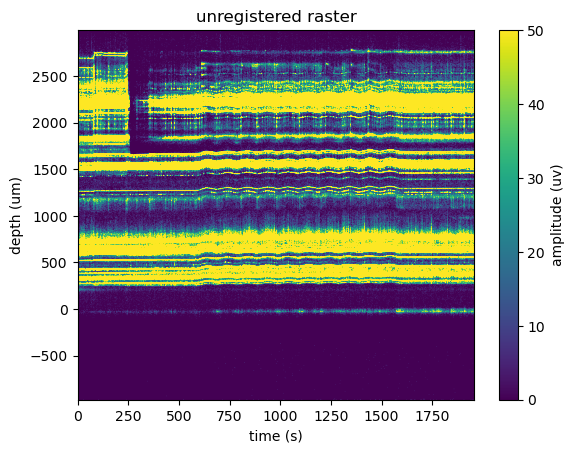

In [16]:
# plot a rasterized view of spiking activity
raster, depth_bin_edges, time_bin_edges = mu.spike_raster(amplitude, depth_um, t_seconds)
mu.show_raster(raster, depth_bin_edges, time_bin_edges, plt, vmax=50, aspect="auto")
plt.colorbar(label="amplitude (uv)")
plt.title("unregistered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)");

In [14]:
# run nonrigid registration
motion_est, extra_info = register(
    amplitude,
    depth_um,
    t_seconds,
    win_scale_um=800,
)

Cross correlation:   0%|          | 0/8 [00:00<?, ?it/s]

Weights:   0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'depth (um)')

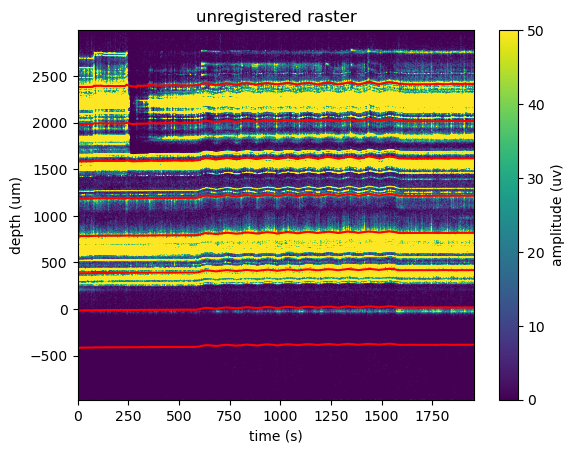

In [17]:
fig, ax = plt.subplots()
im = mu.show_raster(raster, depth_bin_edges, time_bin_edges, ax, vmax=50, aspect="auto")
mu.plot_me_traces(motion_est, plt, c="r")
plt.colorbar(im, ax=ax, label="amplitude (uv)")
plt.title("unregistered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)")

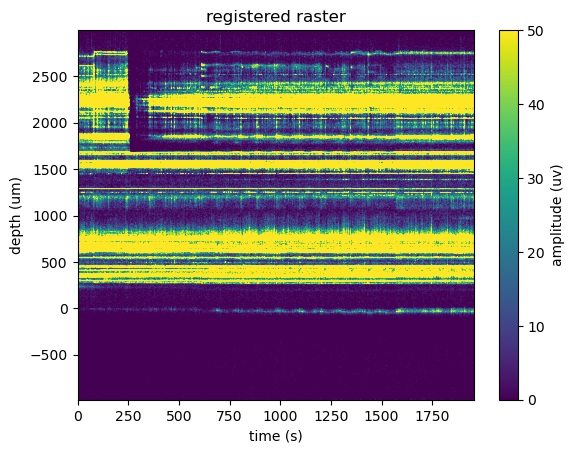

In [18]:
mu.show_registered_raster(motion_est, amplitude, depth_um, t_seconds, plt, vmax=50, aspect="auto")
plt.colorbar(label="amplitude (uv)")
plt.title("registered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)");

In [19]:
# rigid registration
motion_est_rigid, extra_info_rigid = register(
    amplitude,
    depth_um,
    t_seconds,
    rigid=True,
)

Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

Weights:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'depth (um)')

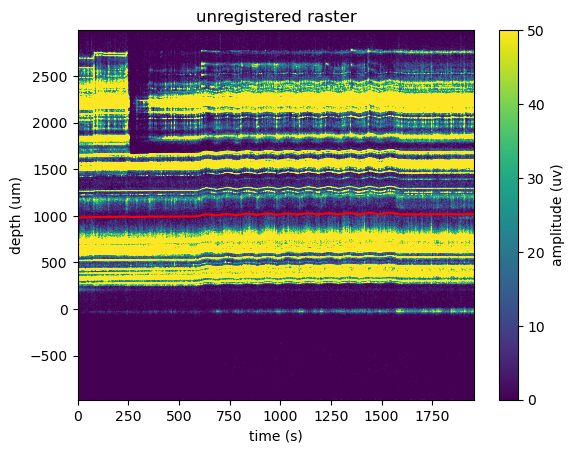

In [20]:
fig, ax = plt.subplots()
mu.show_raster(raster, depth_bin_edges, time_bin_edges, plt, vmax=50, aspect="auto")
mu.plot_me_traces(motion_est_rigid, ax, c="r")
plt.colorbar(label="amplitude (uv)")
plt.title("unregistered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)")

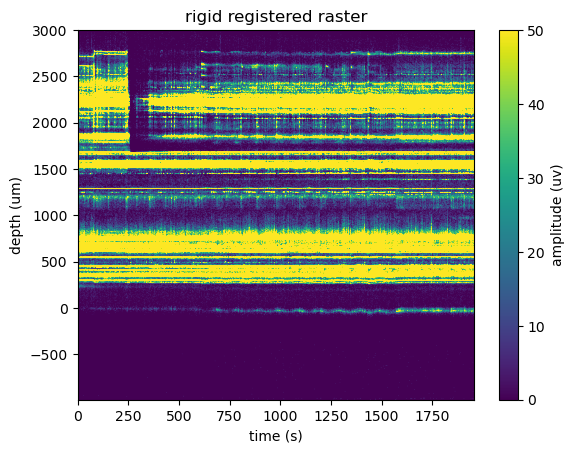

In [21]:
mu.show_registered_raster(motion_est_rigid, amplitude, depth_um, t_seconds, plt, vmax=50, aspect="auto")
plt.colorbar(label="amplitude (uv)")
plt.title("rigid registered raster")
plt.xlabel("time (s)")
plt.ylabel("depth (um)");

In [22]:
# quick tutorial: what are the motion_est objects?
# starting with the rigid version...

In [23]:
motion_est_rigid

In [24]:
# the displacement vector is stored in .displacement
motion_est_rigid.displacement.shape

(1957,)

In [25]:
# but you can also get the displacement (in microns) at arbitrary times (in seconds)
motion_est_rigid.disp_at_s([10, 20, 100])
# you could input, for instance, time stamps at a different sampling rate to translate
# between sampling rates. but, keep in mind that this thing is doing linear interpolation,
# which may not be the best strategy depending on the application. we could extend to other
# options if helpful!

array([-26.12542653, -26.07585922, -21.43846905])

In [26]:
# and the nonrigid? it has a matrix of displacements
motion_est.displacement.shape

(8, 1957)

In [29]:
# and it needs to know the depth when getting the displacement
motion_est.disp_at_s([10, 20, 100], depth_um=[1000, 1000, 2000])

array([-26.51273338, -26.45735545, -18.5416599 ])

In [30]:
# these objects can also motion-correct our spike positions
depth_reg = motion_est.correct_s(t_seconds, depth_um)

In [31]:
# depth_um - depth_reg is the displacement of each spike
np.all(np.isclose(depth_um - depth_reg, motion_est.disp_at_s(t_seconds, depth_um)))

True